<a href="https://colab.research.google.com/github/tozanni/Data_Science_Notebooks/blob/main/CIFAR10_Autoencoder_CNN_wNoise_SinSolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Usando un autoencoder para reducir el ruido de los datos

In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()


170508288/170498071 [==============================] - 14s 0us/step


Verificando la cantidad de imagenes en el dataset y su dimension, en este caso recibimos 50,000 imagenes de 32x32 x 3 canales de color.


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Normalización


In [ ]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Datos generales
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


In [ ]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

## Agregar ruido a las imágenes

El training set se dividira en 40,000 imagenes con ruido y 10,000 imagenes sin ruido.

In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)


Mostrar imágenes originales y con ruido

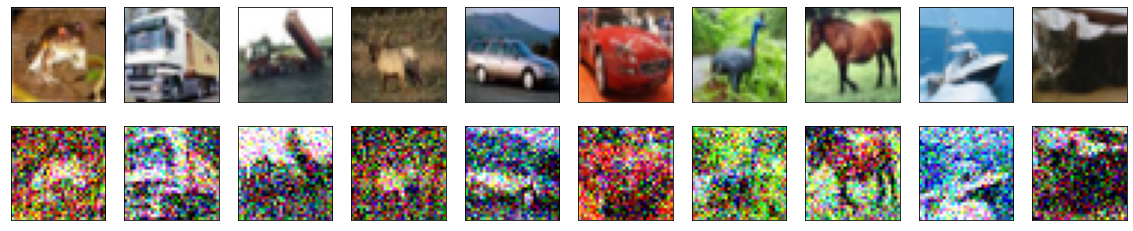

In [ ]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

showOrigDec(x_train, x_train_noisy)

In [ ]:
# Se codifican las etiquetas como one-hot, posteriormente se utilizará la función de categorical-cross-entropy
num_classes = 10
y_train_labels = np_utils.to_categorical(y_train, num_classes)
y_test_labels = np_utils.to_categorical(y_test, num_classes)


In [ ]:
# Dividir etiquetas de validacion
y_val_labels = y_test_labels[:7000]
y_test_labels = y_test_labels[7000:]

In [ ]:
y_val_labels.shape

(7000, 10)

In [ ]:
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, MaxPool2D, Flatten, BatchNormalization, ReLU
import keras.backend as K
from keras.models import Model
from keras.metrics import mean_squared_error

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


## Autoencoder para eliminación de ruido

La arquitectura para denoising consiste de los siguientes componentes:
 
- 4 bloques convolucionales con downsampling
- 1 bloque convolucional sin downsampling
- 4 bloques deconvolucionales con upsampling, se intercalan concatenaciones
- 1 convolución final que recrea la imagen requerida de tamaño (32, 32, 3)
- 1 capa de activación sigmoidal que escala los valores entre 0 y 1

In [ ]:
dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
conv_block1 = conv_block(dae_inputs, 32, 3)
conv_block2 = conv_block(conv_block1, 64, 3)
conv_block3 = conv_block(conv_block2, 128, 3)
conv_block4 = conv_block(conv_block3, 256, 3)
conv_block5 = conv_block(conv_block4, 256, 3, 1)

deconv_block1 = deconv_block(conv_block5, 256, 3)
merge1 = Concatenate()([deconv_block1, conv_block3])
deconv_block2 = deconv_block(merge1, 128, 3)
merge2 = Concatenate()([deconv_block2, conv_block2])
deconv_block3 = deconv_block(merge2, 64, 3)
merge3 = Concatenate()([deconv_block3, conv_block1])
deconv_block4 = deconv_block(merge3, 32, 3)

final_deconv = Conv2DTranspose(filters=3, kernel_size=3, padding='same')(deconv_block4)
dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)

In [ ]:
# Modelo Encoder-Decoder
model = Model(dae_inputs, dae_outputs)
#model.compile(optimizer='adam', loss='binary_crossentropy')

# Referencia original con MSE
model.compile(loss='mse', optimizer='adam')
model.summary()


### Ejercicio:

¿Cuál de los siguientes métodos es el correcto para implementar un autoencoder que aprenda a reconstruir los datos sin ruido (x_train) a partir del conjunto de datos con ruido (x_train_noisy)?

Prueba tu respuesta en la siguiente línea:

In [ ]:
### history = model.fit(...)

## Visualización del input reconstruido

En este caso, el método predict de Keras entrega el input reconstruido.

In [ ]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)
print(c10test.shape)
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

(3000, 32, 32, 3)
Cifar10_test: 0.4725196361541748
Cifar10_val: 0.475754976272583


In [ ]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

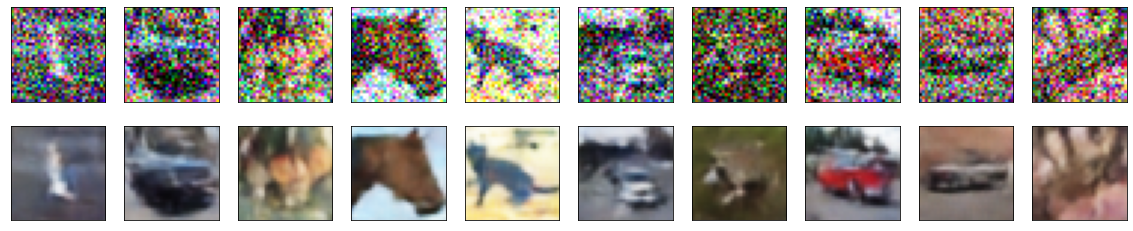

In [ ]:
showOrigDec(x_test_noisy, c10test)

## Siguientes pasos

1. Utilizar el modelo de Autoencoder para limpiar el ruido de nuestro training, validation y test sets.

2. Entrenar y correr nuevamente el modelo CNN con los conjuntos de datos sin ruido.

3. Validar cuánto sube la métrica de F1 score al eliminar el ruido. 

4. Compara el resultado con el modelo CNN entrenado con aumentación de datos. 


## Modelo de clasificación

Para este training set, utilizaremos las imágenes originales y adicionalmente lo aumentaremos con las imágenes una vez procesadas por el eliminador de ruido.

#### Eliminación de ruido

A continuación utilizaremos nuestro autoencoder para eliminar el ruido de las imágenes y poder aumentar nuestro training set con imágenes sin ruido (x_train_clean, val_images_clean y test_images_clean)

In [ ]:
train_images_clean = model.predict(x_train_noisy)
val_images_clean = model.predict(x_val_noisy)
test_images_clean = model.predict(x_test_noisy)

print(train_images_clean.shape)
print(y_train_labels.shape)

print(val_images_clean.shape)
print(y_val_labels.shape)

print(test_images_clean.shape)
print(y_test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(7000, 32, 32, 3)
(7000, 10)
(3000, 32, 32, 3)
(3000, 10)


A continuación produciremos un dataset aumentado. 

Recuerda que es necesario también aumentar los training_labels aunque en este caso no necesitas hacer ninguna transformación.

## Ejercicio

Utilizando los métodos de aumentación conocidos genera:

x_train_aug, concatenando x_train y train_images_clean sobre el eje 0.

y_train_aug, concatendado y_train_labels dos veces sobre el eje 0.

In [ ]:
## Aumenta los datos requeridos....


# print(x_train_aug.shape)
# print(y_train_aug.shape)

(100000, 32, 32, 3)
(100000, 10)


## Ejercicio

Implementa el modelo convolucional de clasificación que ya conoces en la siguiente sección.

In [ ]:
model = Sequential()

## Completa el modelo ....

model.summary()

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# Entrenar con el conjunto de datos aumentado, original + denoised
# Validar con el conjunto de datos denoised

# history = model.fit(x_train_aug, y_train_aug, batch_size=64, epochs=20, validation_data=(val_images_clean, y_val_labels))

Text(0.5, 1.0, 'Loss Curves')

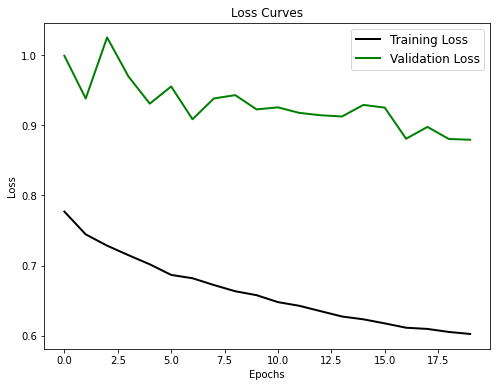

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# Making the Predictions
pred = model.predict(test_images_clean)
print(pred)

# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

[[6.47012368e-02 9.65759100e-04 7.33318448e-01 ... 2.02040412e-02
  2.08998173e-02 1.78659731e-03]
 [1.84866876e-05 9.93619144e-01 2.63425500e-05 ... 9.92036803e-07
  2.37672916e-03 3.83797614e-03]
 [1.15245304e-04 8.39151791e-04 9.90454108e-03 ... 4.50350670e-03
  1.53419736e-04 1.23959349e-03]
 ...
 [1.35311529e-05 6.81509046e-05 5.61855081e-03 ... 2.32305727e-03
  2.22166273e-04 3.34081706e-04]
 [1.55458093e-01 3.12819570e-01 3.07447501e-02 ... 1.48589793e-03
  1.34330736e-02 1.00261681e-02]
 [5.18115576e-06 5.66183780e-06 2.11251288e-04 ... 9.71351624e-01
  7.33306763e-07 1.74191755e-05]]
[2 1 5 ... 5 4 7]


## Ejercicio: Genera la matriz de confusión del modelo

In [ ]:
## Matriz de confusion



Estos resultados son sólo un poco mejores a los obtenidos con un clasificador entrenado con una aumentación de datos con ruido, sin embargo, este método tiene la ventaja de que gracias al uso del modelo autoencoder para eliminación de ruido, es posible utilizar el clasificador original (entrenado con imágenes sin ruido) en esta tarea, con resultados aceptables. 

Referencias: 

https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook

https://github.com/shibuiwilliam/Keras_Autoencoder/blob/master/Cifar_Conv_AutoEncoder.ipynb

https://github.com/shibuiwilliam/Keras_Autoencoder/blob/master/Cifar_Denoise_AutoEncoder.ipynb

https://codahead.com/blog/a-denoising-autoencoder-for-cifar-datasets

https://openaccess.thecvf.com/content_ICCV_2017/papers/Tong_Image_Super-Resolution_Using_ICCV_2017_paper.pdf
